INITIALISING THE DATASET

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
from datetime import datetime

# Load and preprocess the data
options_data = pd.read_csv('/content/options_SPX.csv')  # Assuming you've saved the options data as CSV
libor_data = pd.read_csv('/content/libor_without12M.csv')

# Ensure dates are in datetime format
options_data['Date'] = pd.to_datetime(options_data['Date'], format='%Y-%m-%d')
options_data['expiration_date'] = pd.to_datetime(options_data['expiration_date'], format='%Y-%m-%d')

# Create year-month column for later aggregation
options_data['year_month'] = options_data['Date'].dt.to_period('M')

# Merge LIBOR data (if required)
# Ensure the LIBOR dataset has datetime and merge with options data on 'Date' if necessary
libor_data['Date'] = pd.to_datetime(libor_data['Date'], format='%Y-%m-%d')
options_data = options_data.merge(libor_data, on='Date', how='left')

BASELINE/ALWAYS SHORT STRADDLE IMPLEMENTATION


<ipython-input-2-1ae8e5c4814c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_data['Date'] = pd.to_datetime(options_data['Date'])
<ipython-input-2-1ae8e5c4814c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options_data['expiration_date'] = pd.to_datetime(options_data['expiration_date'])


    year_month   returns  sharpe_ratio  hit_ratio
0      2014-01 -0.671821     -0.468898   0.619048
1      2014-02 -1.670603     -1.860269   0.368421
2      2014-03  0.690525      0.888614   0.619048
3      2014-04 -0.872491     -0.959549   0.333333
4      2014-05  0.386723      0.748582   0.523810
..         ...       ...           ...        ...
119    2023-12  0.315386      2.653060   0.700000
120    2024-01  0.171605      3.067210   0.761905
121    2024-02  0.206182      2.579335   0.700000
122    2024-03  0.579158      4.989002   0.800000
123    2024-04  0.671275      3.951035   0.818182

[124 rows x 4 columns]
Metrics saved to always_short_straddle_baseline_metrics.csv


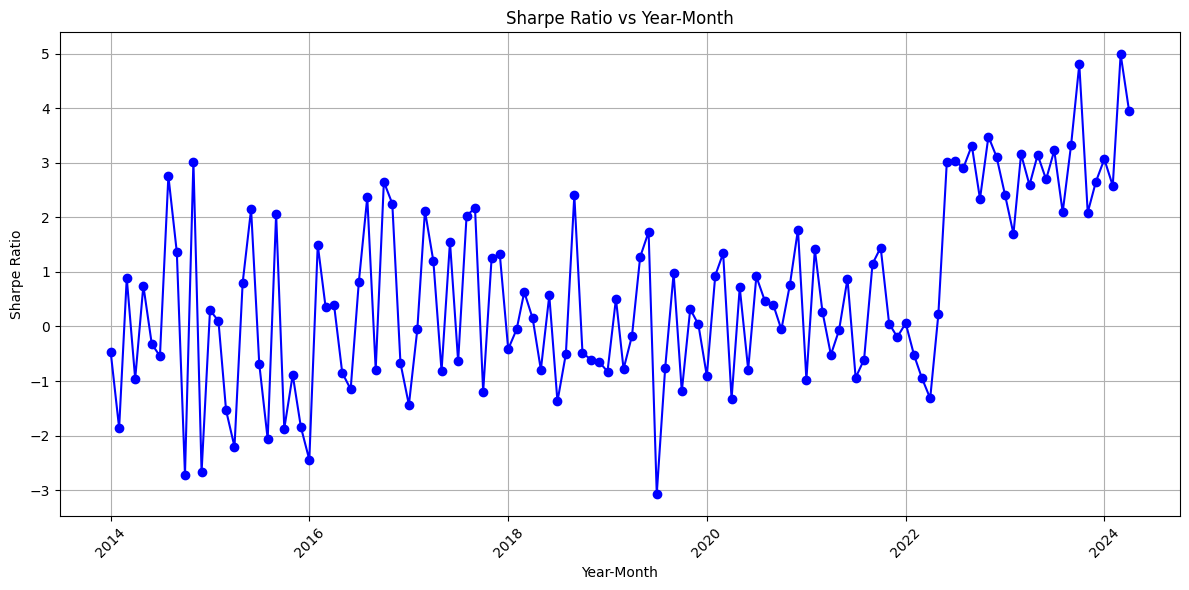

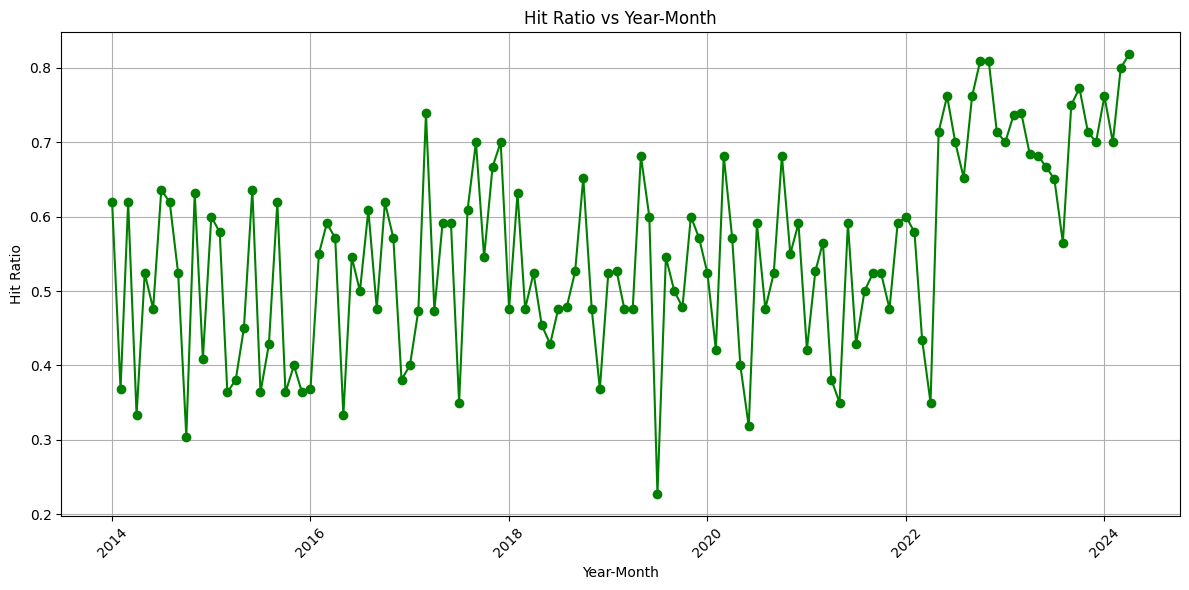

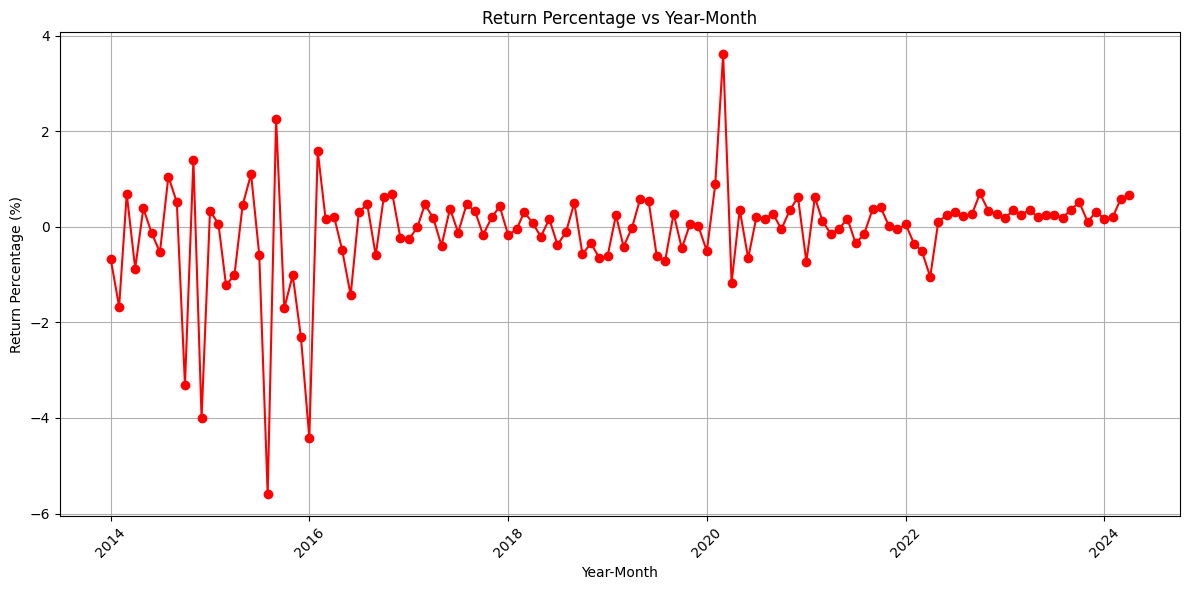

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Pre-process the data
def preprocess_data(options_data):
    # Ensure your dates and expiration dates are properly formatted
    options_data['Date'] = pd.to_datetime(options_data['Date'])
    options_data['expiration_date'] = pd.to_datetime(options_data['expiration_date'])
    return options_data

# Step 2: Calculate margin based on the premium and prices
def calculate_margin(premium_collected, underlying_price_start, strike_price):
    otm_call = max(0, strike_price - underlying_price_start)
    otm_put = max(0, underlying_price_start - strike_price)
    otm_amount = otm_call + otm_put

    margin_put = premium_collected + max(0.15 * underlying_price_start - otm_amount, 0.10 * strike_price)
    margin_call = premium_collected + max(0.15 * underlying_price_start - otm_amount, 0.10 * underlying_price_start)

    return max(margin_put, margin_call)

# Step 3: Implement short straddle strategy and hold until expiry
def short_straddle_hold_until_expiry(data):
    results = []

    # Group the data by each day
    daily_data = data.groupby(data['Date'])

    for day, day_data in daily_data:
        # Get the first entry for the day to establish the ATM position
        first_day = day_data.iloc[0]
        underlying_price_start = first_day['underlying_price']

        # Find the ATM strike price (closest to the underlying price)
        day_data['strike_diff'] = abs(day_data['price_strike'] - underlying_price_start)
        atm_options = day_data.loc[day_data.groupby('call_put')['strike_diff'].idxmin()]

        # Ensure both Call and Put options are present for the ATM
        atm_call = atm_options[atm_options['call_put'] == 'C']
        atm_put = atm_options[atm_options['call_put'] == 'P']

        if atm_call.empty or atm_put.empty:
            continue  # Skip if no valid ATM options are found

        # Collect premiums at the start of the day for short straddle (Bid prices)
        premium_collected = atm_call['Bid'].values[0] + atm_put['Bid'].values[0]

        # Find the expiration date for the options
        expiration_date = atm_call['expiration_date'].values[0]
        expiry_data = data[data['Date'] == expiration_date]

        # Find the last available price before expiration if no expiration data
        if expiry_data.empty:
            last_available_data = data[data['Date'] < expiration_date]
            if not last_available_data.empty:
                expiry_data = last_available_data.iloc[-1:]  # Get the last available entry

        if expiry_data.empty:
            continue  # Skip if no available data for expiration

        # Get the underlying price at expiration or the last available price
        underlying_price_expiry = expiry_data['underlying_price'].values[0]

        # Calculate PnL for the short straddle
        pnl = premium_collected - abs(atm_call['price_strike'].values[0] - underlying_price_expiry)

        # Calculate margin
        margin = calculate_margin(premium_collected, underlying_price_start, atm_call['price_strike'].values[0])

        # Store results
        results.append({
            'date': day,
            'underlying_price_start': underlying_price_start,
            'underlying_price_expiry': underlying_price_expiry,
            'atm_strike': atm_call['price_strike'].values[0],
            'premium_collected': premium_collected,
            'pnl': pnl,
            'margin': margin,  # Add margin to the results
        })

    return pd.DataFrame(results)

# Step 4: Calculate financial metrics (Sharpe Ratio, Hit Ratio, Returns)
def calculate_metrics(results):
    # Group by Year-Month and calculate monthly PnL and trades
    results['year_month'] = results['date'].dt.to_period('M')

    # Monthly PnL and Margin calculations
    monthly_pnl = results.groupby('year_month').agg({
        'pnl': 'sum',
        'margin': 'sum',  # Sum of margins for the month
        'date': 'count'  # Number of trades in the month
    }).rename(columns={'date': 'num_trades'}).reset_index()

    # Calculate returns as percentage of margin
    monthly_pnl['returns'] = (monthly_pnl['pnl'] / monthly_pnl['margin']) * 100

    # Sharpe Ratio calculation for each month
    def calculate_sharpe(pnl_data):
        mean_pnl = np.mean(pnl_data)
        std_dev_pnl = np.std(pnl_data, ddof=1)
        num_trades = len(pnl_data)
        return np.sqrt(num_trades) * (mean_pnl / std_dev_pnl) if std_dev_pnl != 0 else 0

    # Apply the Sharpe calculation
    monthly_pnl['sharpe_ratio'] = monthly_pnl.apply(lambda row: calculate_sharpe(results[results['year_month'] == row['year_month']]['pnl']), axis=1)

    # Hit Ratio: Percentage of profitable trades
    results['profitable'] = results['pnl'] > 0
    hit_ratios = results.groupby('year_month')['profitable'].mean().reset_index()
    monthly_pnl = pd.merge(monthly_pnl, hit_ratios, on='year_month', how='left').rename(columns={'profitable': 'hit_ratio'})

    return monthly_pnl

# Step 5: Plotting the metrics
def plot_metrics(monthly_pnl):
    # Plot Sharpe Ratio vs Year-Month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['sharpe_ratio'], label='Sharpe Ratio', marker='o', color='b')
    plt.title('Sharpe Ratio vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Sharpe Ratio')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot Hit Ratio vs Year-Month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['hit_ratio'], label='Hit Ratio', marker='o', color='g')
    plt.title('Hit Ratio vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Hit Ratio')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot Return Percentage vs Year-Month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['returns'], label='Return Percentage', marker='o', color='r')
    plt.title('Return Percentage vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Return Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Step 6: Save the metrics to a CSV file
def save_to_csv(monthly_pnl, filename='straddle_metrics.csv'):
    # Save the required columns into a CSV file
    monthly_pnl[['year_month', 'returns', 'sharpe_ratio', 'hit_ratio']].to_csv(filename, index=False)
    print(f"Metrics saved to {filename}")

# Step 7: Main function to execute all steps
def main(options_data):
    # Apply date restriction from 2014 to 2024
    options_data = options_data[(options_data['Date'] >= '2014-01-01') & (options_data['Date'] <= '2024-12-31')]

    # Preprocess the data
    options_data = preprocess_data(options_data)

    # Execute the short straddle hold-until-expiry strategy
    straddle_results = short_straddle_hold_until_expiry(options_data)

    # Calculate metrics (Sharpe Ratio, Hit Ratio, Monthly Returns)
    monthly_pnl = calculate_metrics(straddle_results)

    # Print the results in the expected format
    print(monthly_pnl[['year_month', 'returns', 'sharpe_ratio', 'hit_ratio']])

    # Save the metrics to a CSV file
    save_to_csv(monthly_pnl, filename='always_short_straddle_baseline_metrics.csv')

    # Plot the metrics
    plot_metrics(monthly_pnl)

# Call the main function
main(options_data)

XGBOOST CLASSIFIER IMPLEMENTATION OF SHORT STRADDLE

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:47:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-4-1fa69bb7ab04>:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted'] = model.predict(X_test)
<ipython-input-4-1fa69bb7ab04>:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['year_month'] = results['date'].dt.to_period('M')
/usr/local/lib/python3.10/dist-

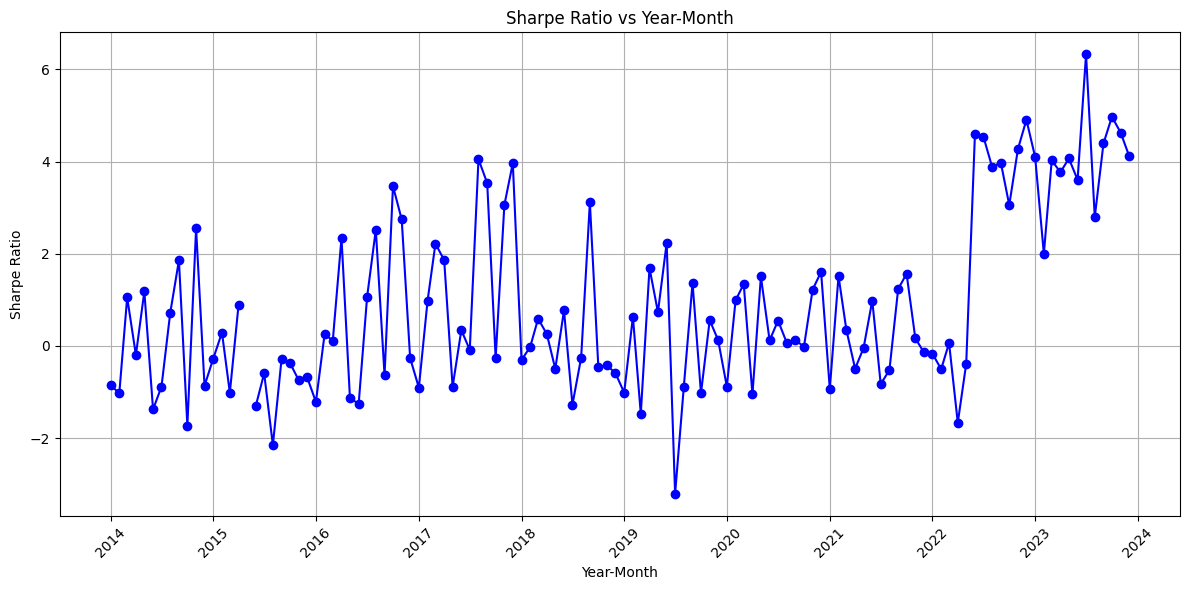

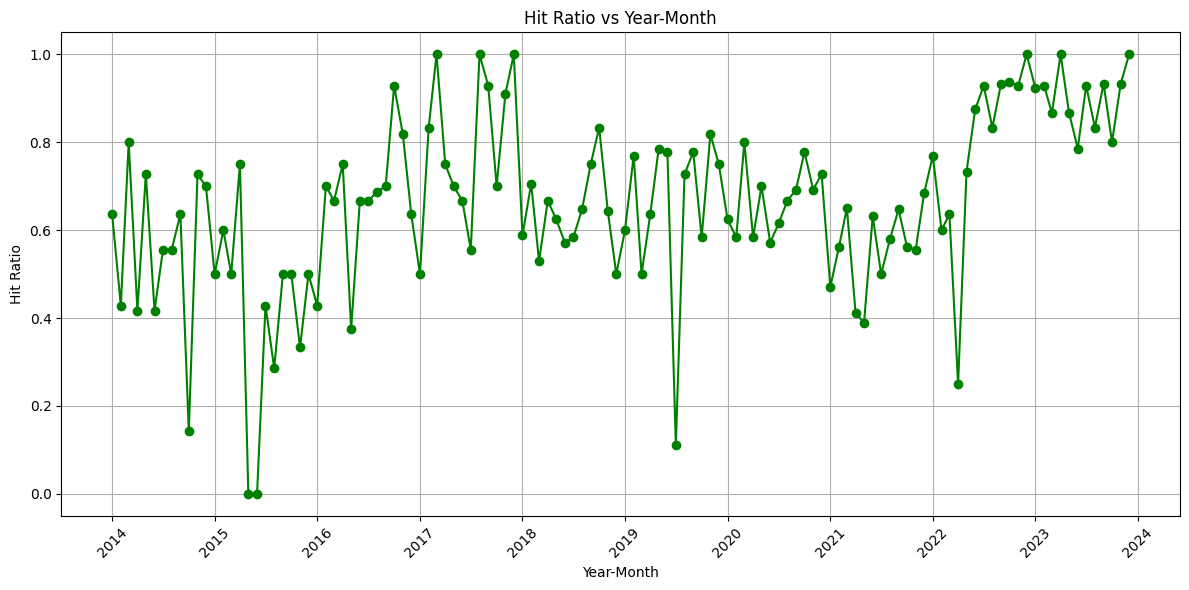

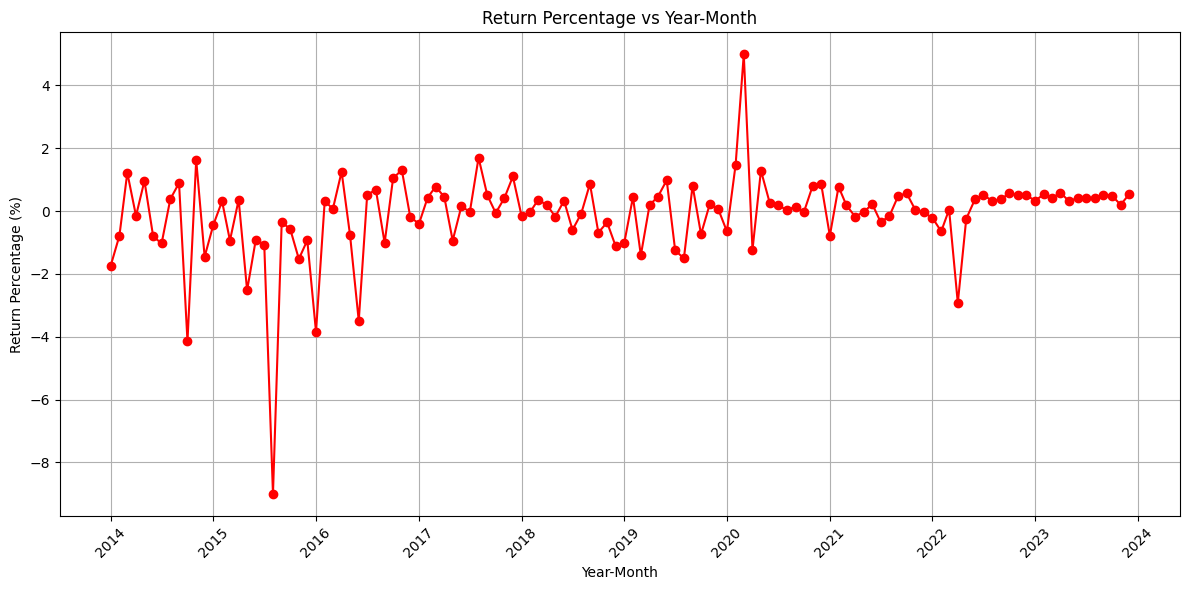

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Step 1: Pre-process the data
def preprocess_data(options_data):
    options_data['Date'] = pd.to_datetime(options_data['Date'])
    options_data['expiration_date'] = pd.to_datetime(options_data['expiration_date'])
    return options_data

# Step 2: Calculate margin based on premium and prices
def calculate_margin(premium_collected, underlying_price_start, strike_price):
    otm_call = max(0, strike_price - underlying_price_start)
    otm_put = max(0, underlying_price_start - strike_price)
    otm_amount = otm_call + otm_put

    margin_put = premium_collected + max(0.15 * underlying_price_start - otm_amount, 0.10 * strike_price)
    margin_call = premium_collected + max(0.15 * underlying_price_start - otm_amount, 0.10 * underlying_price_start)

    return max(margin_put, margin_call)

# Step 3: Implement short straddle strategy and calculate PnL with profitable column
def short_straddle_pnl(data):
    results = []
    daily_data = data.groupby(data['Date'])

    for day, day_data in daily_data:
        first_day = day_data.iloc[0]
        underlying_price_start = first_day['underlying_price']

        # Find the ATM strike price (closest to the underlying price)
        day_data['strike_diff'] = abs(day_data['price_strike'] - underlying_price_start)
        atm_options = day_data.loc[day_data.groupby('call_put')['strike_diff'].idxmin()]

        atm_call = atm_options[atm_options['call_put'] == 'C']
        atm_put = atm_options[atm_options['call_put'] == 'P']

        if atm_call.empty or atm_put.empty:
            continue  # Skip if no valid ATM options are found

        # Collect premiums at the start of the day for short straddle (Bid prices)
        premium_collected = atm_call['Bid'].values[0] + atm_put['Bid'].values[0]

        # Expiry date and price at expiry
        expiration_date = atm_call['expiration_date'].values[0]
        expiry_data = data[data['Date'] == expiration_date]

        if expiry_data.empty:
            last_available_data = data[data['Date'] < expiration_date]
            if not last_available_data.empty:
                expiry_data = last_available_data.iloc[-1:]  # Get the last available entry

        if expiry_data.empty:
            continue  # Skip if no available data for expiration

        underlying_price_expiry = expiry_data['underlying_price'].values[0]

        # Calculate PnL for the short straddle
        pnl = premium_collected - abs(atm_call['price_strike'].values[0] - underlying_price_expiry)

        # Calculate margin
        margin = calculate_margin(premium_collected, underlying_price_start, atm_call['price_strike'].values[0])

        # Determine if trade was profitable
        profitable = 1 if pnl > 0 else 0

        # Store results
        results.append({
            'date': day,
            'underlying_price_start': underlying_price_start,
            'underlying_price_expiry': underlying_price_expiry,
            'atm_strike': atm_call['price_strike'].values[0],
            'premium_collected': premium_collected,
            'pnl': pnl,
            'margin': margin,
            'profitable': profitable
        })

    return pd.DataFrame(results)

# Step 4: Prequential training for XGBoost using a 3-year window and retraining every 1 year
def prequential_training(data, start_year, end_year):
    metrics = []

    # Iterate through each year, predicting the next year's results after training on the past 3 years
    for year in range(start_year + 3, end_year + 1):
        # Train on the last 3 years of data and test on the current year
        train_data = data[(data['date'].dt.year >= year - 3) & (data['date'].dt.year < year)]
        test_data = data[data['date'].dt.year == year]

        # Train data: X -> Features, y -> Profitable column
        X_train = train_data[['premium_collected', 'underlying_price_start', 'atm_strike']]
        y_train = train_data['profitable']

        # Initialize and train the XGBoost classifier
        model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
        model.fit(X_train, y_train)

        # Test data for predictions
        if not test_data.empty:
            X_test = test_data[['premium_collected', 'underlying_price_start', 'atm_strike']]
            test_data['predicted'] = model.predict(X_test)

            # Calculate PnL based on predictions (only predict straddle if 'predicted' is 1)
            predicted_straddles = test_data[test_data['predicted'] == 1]
            if not predicted_straddles.empty:
                pnl_metrics = calculate_metrics(predicted_straddles)
                metrics.append(pnl_metrics)

    return pd.concat(metrics, ignore_index=True)

# Step 5: Calculate metrics (Sharpe Ratio, Hit Ratio, Returns)
def calculate_metrics(results):
    results['year_month'] = results['date'].dt.to_period('M')

    # Monthly PnL and Margin calculations
    monthly_pnl = results.groupby('year_month').agg({
        'pnl': 'sum',
        'margin': 'sum',
        'date': 'count'
    }).rename(columns={'date': 'num_trades'}).reset_index()

    # Calculate returns as percentage of margin
    monthly_pnl['returns'] = (monthly_pnl['pnl'] / monthly_pnl['margin']) * 100

    # Sharpe Ratio calculation for each month
    def calculate_sharpe(pnl_data):
        mean_pnl = np.mean(pnl_data)
        std_dev_pnl = np.std(pnl_data, ddof=1)
        num_trades = len(pnl_data)
        return np.sqrt(num_trades) * (mean_pnl / std_dev_pnl) if std_dev_pnl != 0 else 0

    # Apply Sharpe calculation
    monthly_pnl['sharpe_ratio'] = monthly_pnl.apply(
        lambda row: calculate_sharpe(results[results['year_month'] == row['year_month']]['pnl']), axis=1)

    # Hit Ratio: Percentage of profitable trades
    hit_ratios = results.groupby('year_month')['profitable'].mean().reset_index()
    monthly_pnl = pd.merge(monthly_pnl, hit_ratios, on='year_month', how='left').rename(columns={'profitable': 'hit_ratio'})

    return monthly_pnl

# Step 6: Plotting the metrics
def plot_metrics(monthly_pnl):
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['sharpe_ratio'], label='Sharpe Ratio', marker='o', color='b')
    plt.title('Sharpe Ratio vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Sharpe Ratio')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['hit_ratio'], label='Hit Ratio', marker='o', color='g')
    plt.title('Hit Ratio vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Hit Ratio')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['returns'], label='Return Percentage', marker='o', color='r')
    plt.title('Return Percentage vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Return Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Main function to execute all steps
def main(options_data):
    # Preprocess data
    options_data = preprocess_data(options_data)

    # Execute the short straddle strategy and calculate PnL and profitability
    straddle_results = short_straddle_pnl(options_data)

    # Prequential training and prediction using XGBoost, with retraining every 1 year using the past 3 years of data
    prequential_metrics = prequential_training(straddle_results, start_year=2011, end_year=2023)

    # Save the prequential metrics to a CSV file in the expected format
    prequential_metrics.to_csv('xgboost_classifier_results.csv', index=False)

    # Plot the metrics (from 2014 to 2024)
    plot_metrics(prequential_metrics)

# Example usage with options data
main(options_data)

XGBOOST CLASSIFIER FOR LONG-SHORT STRADDLE IMPLEMENTATION

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:49:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-5-55bde21201fe>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted'] = model.predict(X_test)
<ipython-input-5-55bde21201fe>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['year_month'] = results['date'].dt.to_period('M')
<ipython-input-5-55bde21201fe>:

    year_month   returns  sharpe_ratio  hit_ratio
0      2014-01  3.735561      4.007067        0.0
1      2014-02  2.468185      4.007067        0.0
2      2014-03  2.590627      6.480815        0.0
3      2014-04  2.572078      8.844491        0.0
4      2014-05  1.402862      6.890453        0.0
..         ...       ...           ...        ...
119    2023-12  0.412689     10.127994        0.0
120    2024-01  0.217347     12.643633        0.0
121    2024-02  0.186753     12.643633        0.0
122    2024-03  0.606801      2.421568        0.0
123    2024-04  0.694609      3.524910        0.0

[124 rows x 4 columns]


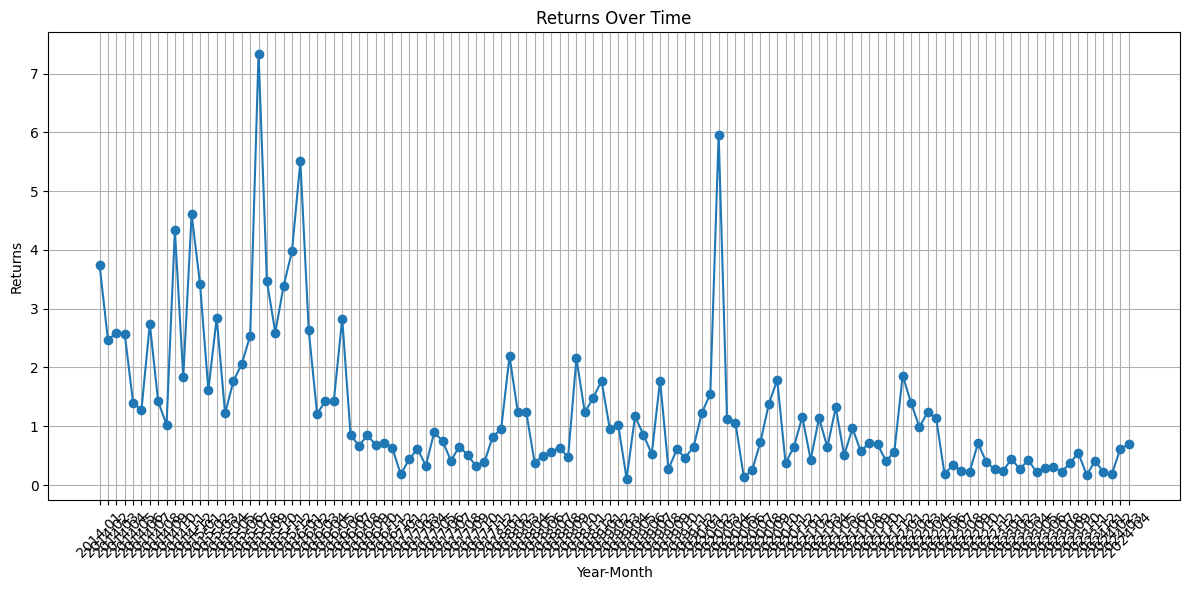

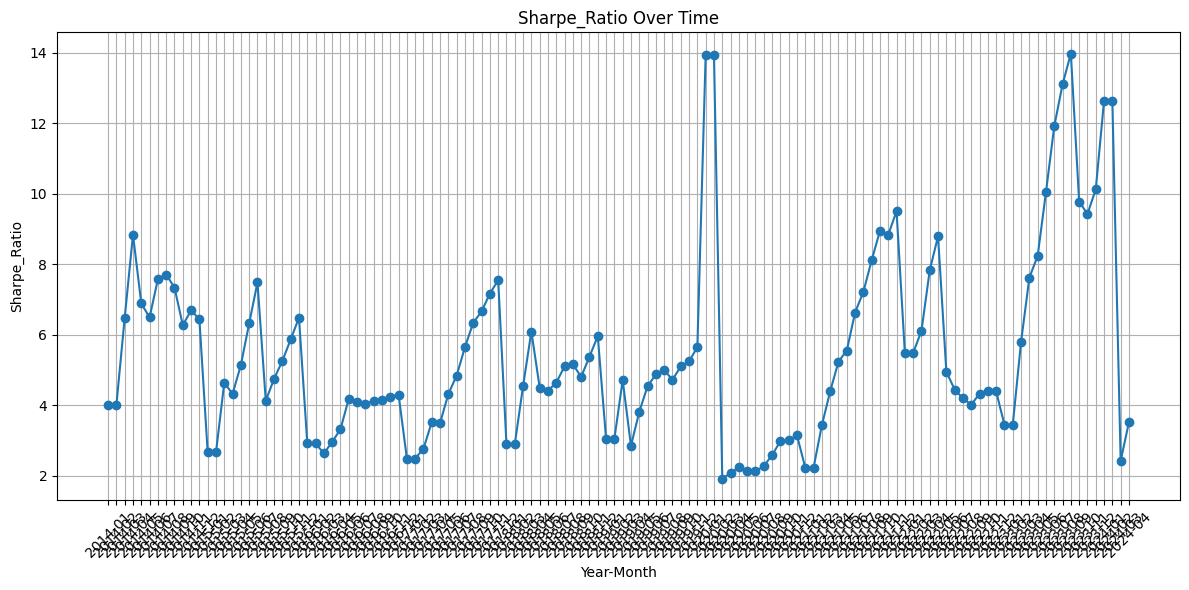

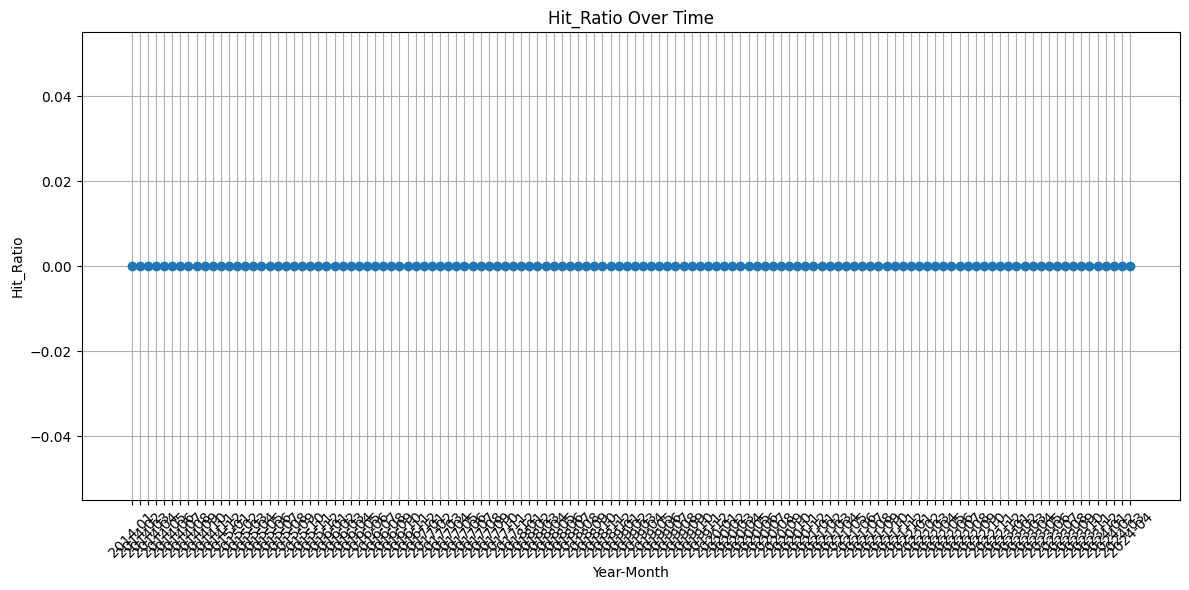

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# Step 1: Pre-process the data
def preprocess_data(options_data):
    options_data.columns = options_data.columns.str.strip()
    options_data['Date'] = pd.to_datetime(options_data['Date'], format='%d-%m-%Y', errors='coerce')
    options_data['expiration_date'] = pd.to_datetime(options_data['expiration_date'], format='%d-%m-%Y', errors='coerce')
    options_data.dropna(subset=['Date', 'expiration_date'], inplace=True)
    return options_data

# Step 2: Calculate margin based on premium and prices for both strategies
def calculate_margin(premium_collected, underlying_price_start, strike_price):
    otm_call = max(0, strike_price - underlying_price_start)
    otm_put = max(0, underlying_price_start - strike_price)
    otm_amount = otm_call + otm_put

    margin_put = premium_collected + max(0.15 * underlying_price_start - otm_amount, 0.10 * strike_price)
    margin_call = premium_collected + max(0.15 * underlying_price_start - otm_amount, 0.10 * underlying_price_start)

    return max(margin_put, margin_call)

# Step 3: Implement straddle strategy and calculate PnL
def straddle_pnl(data):
    results = []
    daily_data = data.groupby(data['Date'])

    for day, day_data in daily_data:
        first_day = day_data.iloc[0]
        underlying_price_start = first_day['underlying_price']
        day_data['strike_diff'] = abs(day_data['price_strike'] - underlying_price_start)
        atm_options = day_data.loc[day_data.groupby('call_put')['strike_diff'].idxmin()]

        atm_call = atm_options[atm_options['call_put'] == 'C']
        atm_put = atm_options[atm_options['call_put'] == 'P']

        if atm_call.empty or atm_put.empty:
            continue  # Skip if no valid ATM options are found

        # Collect premiums
        premium_collected = atm_call['Bid'].values[0] + atm_put['Bid'].values[0]
        expiration_date = atm_call['expiration_date'].values[0]
        expiry_data = data[data['Date'] == expiration_date]

        if expiry_data.empty:
            last_available_data = data[data['Date'] < expiration_date]
            if not last_available_data.empty:
                expiry_data = last_available_data.iloc[-1:]  # Get the last available entry

        if expiry_data.empty:
            continue  # Skip if no available data for expiration

        underlying_price_expiry = expiry_data['underlying_price'].values[0]
        pnl_short_straddle = premium_collected - abs(atm_call['price_strike'].values[0] - underlying_price_expiry)
        pnl_long_straddle = (max(underlying_price_expiry - atm_call['price_strike'].values[0], 0) +
                             max(atm_put['price_strike'].values[0] - underlying_price_expiry, 0)) - (atm_call['Ask'].values[0] + atm_put['Ask'].values[0])

        # Determine profitability
        profitable = 1 if pnl_short_straddle > 0 else 0  # 1 for short straddle profitability, 0 for long straddle
        pnl = pnl_short_straddle if profitable == 1 else pnl_long_straddle  # Choose pnl based on profitability

        margin = calculate_margin(premium_collected, underlying_price_start, atm_call['price_strike'].values[0])

        results.append({
            'date': day,
            'underlying_price_start': underlying_price_start,
            'underlying_price_expiry': underlying_price_expiry,
            'atm_strike': atm_call['price_strike'].values[0],
            'premium_collected': premium_collected,
            'pnl': pnl,
            'margin': margin,
            'profitable': profitable,
            'strategy': 'straddle'
        })

    return pd.DataFrame(results)

# Step 4: Prequential training for XGBoost using a 3-year window and retraining every 1 year
def prequential_training(data, start_year, end_year):
    metrics = []

    # Iterate through each year, predicting the next year's results after training on the past 3 years
    for year in range(start_year + 3, end_year + 1):
        train_data = data[(data['date'].dt.year >= year - 3) & (data['date'].dt.year < year)]
        test_data = data[data['date'].dt.year == year]

        # Train data: X -> Features, y -> Profitable column
        X_train = train_data[['premium_collected', 'underlying_price_start', 'atm_strike']]
        y_train = train_data['profitable']

        # Set random seed for reproducibility
        np.random.seed(42)
        model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
        model.fit(X_train, y_train)

        # Test data for predictions
        if not test_data.empty:
            X_test = test_data[['premium_collected', 'underlying_price_start', 'atm_strike']]
            test_data['predicted'] = model.predict(X_test)

            # Calculate PnL based on predictions
            pnl_metrics = calculate_metrics(test_data)
            metrics.append(pnl_metrics)

    return pd.concat(metrics, ignore_index=True)

# Step 5: Calculate metrics
def calculate_metrics(results):
    results['year_month'] = results['date'].dt.to_period('M')

    # Monthly PnL and Margin calculations
    monthly_pnl = results.groupby('year_month').agg({
        'pnl': 'sum',
        'margin': 'sum',
        'date': 'count'
    }).rename(columns={'date': 'num_trades'}).reset_index()

    # Calculate returns as a percentage of margin
    monthly_pnl['returns'] = (monthly_pnl['pnl'] / monthly_pnl['margin'].replace(0, np.nan)) * 100  # Avoid division by zero

    # Sharpe Ratio calculation for each month
    def calculate_sharpe(pnl_data):
        mean_pnl = np.mean(pnl_data)
        std_dev_pnl = np.std(pnl_data, ddof=1)
        num_trades = len(pnl_data)
        return (mean_pnl / std_dev_pnl) * np.sqrt(num_trades) if std_dev_pnl > 0 else np.nan

    # Apply the rolling Sharpe ratio with a window size of 3 months
    monthly_pnl['sharpe_ratio'] = monthly_pnl['pnl'].expanding().apply(
        lambda x: calculate_sharpe(x), raw=False
    )

    # Backfill NaN values in the Sharpe ratio
    monthly_pnl['sharpe_ratio'].fillna(method='bfill', inplace=True)

    # Hit Ratio calculation
    total_transactions = results.groupby('year_month')['profitable'].count()
    profitable_transactions = results.groupby('year_month')['profitable'].sum()
    monthly_pnl['hit_ratio'] = profitable_transactions / total_transactions

    # Ensure any remaining NaN values in the hit ratio are filled with 0 (for months with no transactions)
    monthly_pnl['hit_ratio'].fillna(0, inplace=True)

    return monthly_pnl[['year_month', 'returns', 'sharpe_ratio', 'hit_ratio']]

# Step 6: Main execution
options_data = preprocess_data(options_data)
straddle_results = straddle_pnl(options_data)

# Calculate prequential training metrics for both long and short straddles
final_metrics = prequential_training(straddle_results, start_year=2011, end_year=2024)

# Save metrics to CSV
final_metrics.to_csv('metrics.csv', index=False)

# Display final metrics
print(final_metrics)

# Plot metrics
for metric in ['returns', 'sharpe_ratio', 'hit_ratio']:
    plt.figure(figsize=(12, 6))
    plt.plot(final_metrics['year_month'].astype(str), final_metrics[metric], marker='o')
    plt.title(f'{metric.title()} Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel(metric.title())
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

2ND ITM STRATEGY IMPLEMENTATION

    year_month   returns  sharpe_ratio  hit_ratio
0      2013-12 -0.627124           NaN   0.000000
1      2014-01  3.122447      0.771744   0.500000
2      2014-02  4.657714      1.291969   0.750000
3      2014-03  0.523261      0.188997   0.400000
4      2014-04  0.616757      0.487242   0.250000
..         ...       ...           ...        ...
120    2023-12  2.337292      1.279383   0.500000
121    2024-01  0.875008      0.416810   0.600000
122    2024-02  2.859916      1.381056   0.500000
123    2024-03  0.524292      0.612120   0.750000
124    2024-04 -0.043078     -0.007558   0.333333

[125 rows x 4 columns]
Metrics saved to itm_metrics.csv


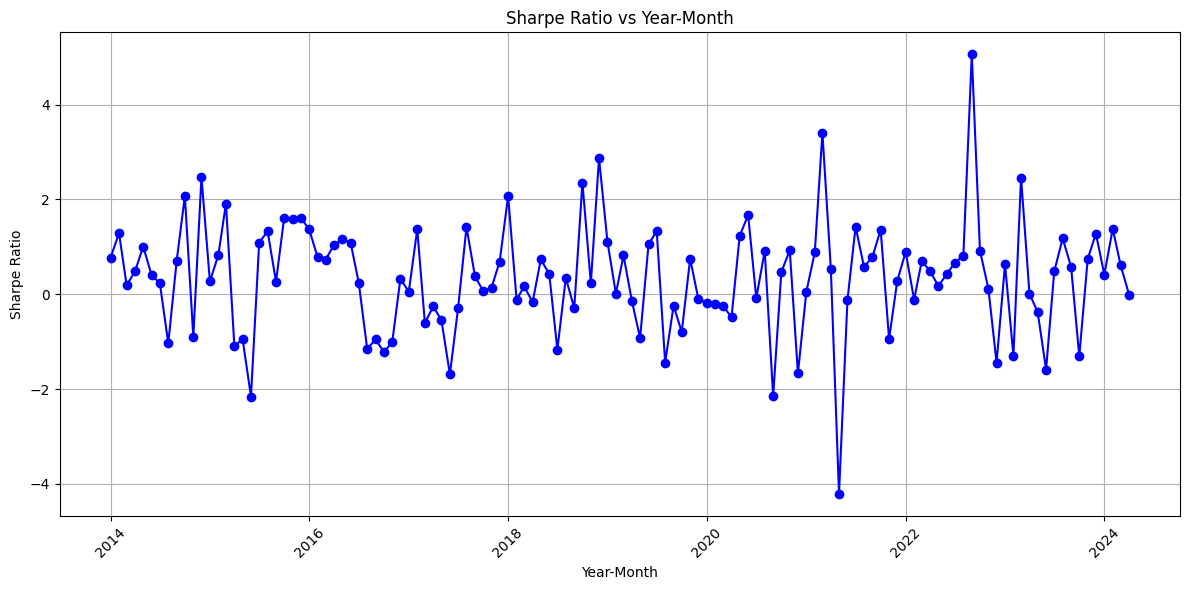

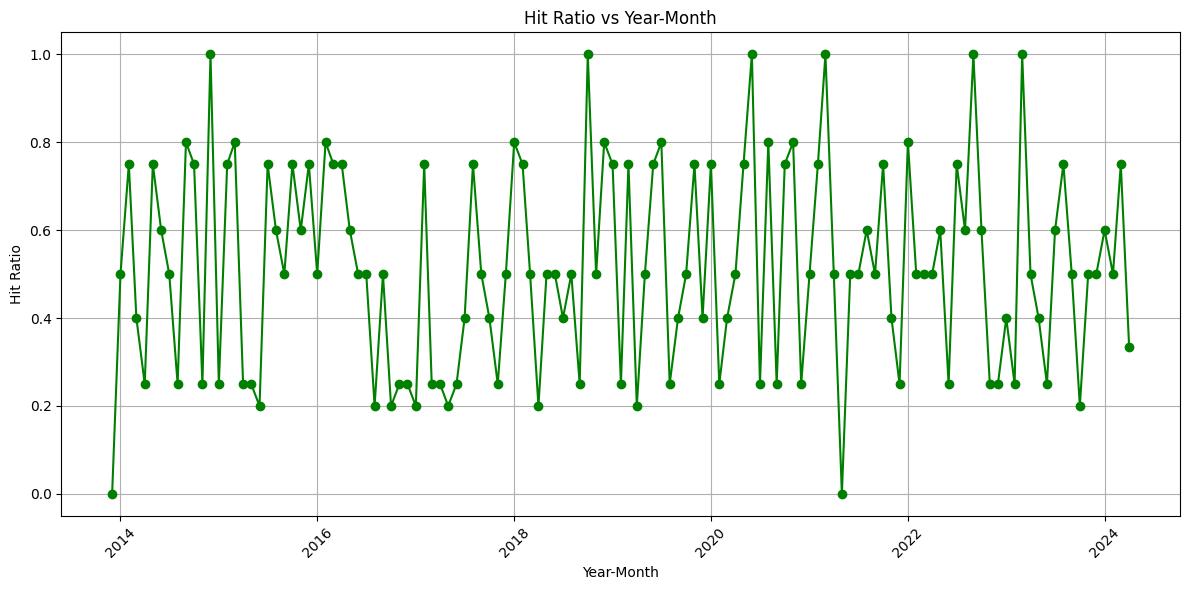

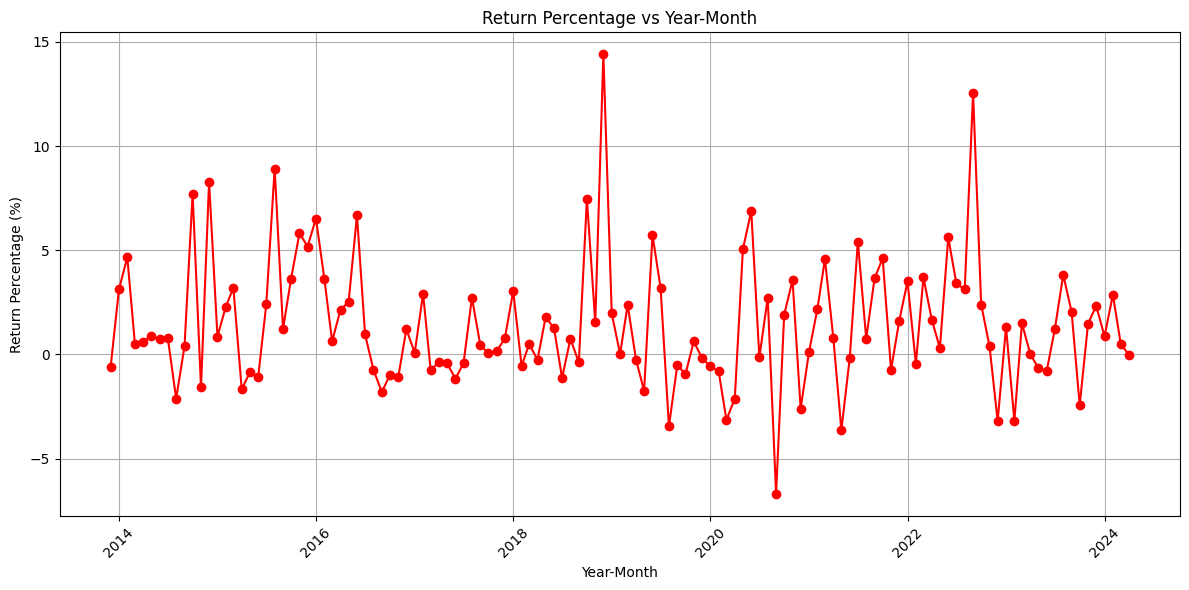

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Pre-process the data
def preprocess_data(options_data):
    # Ensure dates and expiration dates are properly formatted
    options_data['Date'] = pd.to_datetime(options_data['Date'])
    options_data['expiration_date'] = pd.to_datetime(options_data['expiration_date'])
    return options_data

# Step 2: Calculate margin based on premium and prices
def calculate_margin(premium_paid, underlying_price_start, strike_price):
    otm_call = max(0, strike_price - underlying_price_start)
    otm_put = max(0, underlying_price_start - strike_price)
    otm_amount = otm_call + otm_put

    margin_put = premium_paid + max(0.15 * underlying_price_start - otm_amount, 0.10 * strike_price)
    margin_call = premium_paid + max(0.15 * underlying_price_start - otm_amount, 0.10 * underlying_price_start)

    return max(margin_put, margin_call)

# Step 3: Implement long 2nd ITM strategy and hold until expiry
def long_second_itm_hold_until_expiry(data):
    results = []

    # Group the data by weeks
    weekly_data = data.groupby(data['Date'].dt.to_period('W'))

    for week, week_data in weekly_data:
        # Get the first entry for the week to establish the underlying price
        first_day = week_data.iloc[0]
        underlying_price_start = first_day['underlying_price']

        # Identify ITM options
        week_data['strike_diff'] = underlying_price_start - week_data['price_strike']
        itm_options = week_data[week_data['strike_diff'] > 0].sort_values(by='strike_diff')

        if len(itm_options) < 2:
            continue  # Skip if there are fewer than 2 ITM options

        # Get the 2nd ITM Call and Put options
        second_itm_call = itm_options[itm_options['call_put'] == 'C'].iloc[1]
        second_itm_put = itm_options[itm_options['call_put'] == 'P'].iloc[1]

        # Premium paid at the start of the week
        premium_paid = second_itm_call['Bid'] + second_itm_put['Bid']

        # Find expiration day data
        expiration_date = second_itm_call['expiration_date']
        expiry_data = data[data['Date'] == expiration_date]

        # If there's no data for the expiration date, find the last available data
        if expiry_data.empty:
            last_available_data = data[data['Date'] < expiration_date]
            if not last_available_data.empty:
                expiry_data = last_available_data.iloc[-1:]  # Get the last available entry before expiration

        if expiry_data.empty:
            continue  # Skip if no available data for expiration

        # Get the underlying price at expiration or the last available price
        underlying_price_expiry = expiry_data['underlying_price'].values[0]

        # Calculate PnL for the long position
        pnl = (max(underlying_price_expiry - second_itm_call['price_strike'], 0) +
               max(second_itm_put['price_strike'] - underlying_price_expiry, 0)) - premium_paid

        # Calculate margin
        margin = calculate_margin(premium_paid, underlying_price_start, second_itm_call['price_strike'])

        # Store results
        results.append({
            'week': week.start_time,
            'underlying_price_start': underlying_price_start,
            'underlying_price_expiry': underlying_price_expiry,
            '2nd_itm_call_strike': second_itm_call['price_strike'],
            '2nd_itm_put_strike': second_itm_put['price_strike'],
            'premium_paid': premium_paid,
            'pnl': pnl,
            'margin': margin,
        })

    return pd.DataFrame(results)

# Step 4: Calculate financial metrics (Sharpe Ratio, Hit Ratio, Returns)
def calculate_metrics(results):
    # Group by Year-Month and calculate monthly PnL and trades
    results['year_month'] = results['week'].dt.to_period('M')

    # Monthly PnL and Margin calculations
    monthly_pnl = results.groupby('year_month').agg({
        'pnl': 'sum',
        'margin': 'sum',  # Sum of margins for the month
        'week': 'count'  # Number of trades in the month
    }).rename(columns={'week': 'num_trades'}).reset_index()

    # Calculate returns as percentage of margin
    monthly_pnl['returns'] = (monthly_pnl['pnl'] / monthly_pnl['margin']) * 100

    # Sharpe Ratio calculation for each month
    def calculate_sharpe(pnl_data):
        mean_pnl = np.mean(pnl_data)
        std_dev_pnl = np.std(pnl_data, ddof=1)
        num_trades = len(pnl_data)
        return np.sqrt(num_trades) * (mean_pnl / std_dev_pnl) if std_dev_pnl != 0 else 0

    # Apply the Sharpe calculation
    monthly_pnl['sharpe_ratio'] = monthly_pnl.apply(lambda row: calculate_sharpe(results[results['year_month'] == row['year_month']]['pnl']), axis=1)

    # Hit Ratio: Percentage of profitable trades
    results['profitable'] = results['pnl'] > 0
    hit_ratios = results.groupby('year_month')['profitable'].mean().reset_index()
    monthly_pnl = pd.merge(monthly_pnl, hit_ratios, on='year_month', how='left').rename(columns={'profitable': 'hit_ratio'})

    return monthly_pnl

# Step 5: Plotting the metrics
def plot_metrics(monthly_pnl):
    # Plot Sharpe Ratio vs Year-Month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['sharpe_ratio'], label='Sharpe Ratio', marker='o', color='b')
    plt.title('Sharpe Ratio vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Sharpe Ratio')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot Hit Ratio vs Year-Month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['hit_ratio'], label='Hit Ratio', marker='o', color='g')
    plt.title('Hit Ratio vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Hit Ratio')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot Return Percentage vs Year-Month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_pnl['year_month'].dt.to_timestamp(), monthly_pnl['returns'], label='Return Percentage', marker='o', color='r')
    plt.title('Return Percentage vs Year-Month')
    plt.xlabel('Year-Month')
    plt.ylabel('Return Percentage (%)')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Step 6: Save the metrics to a CSV file
def save_to_csv(monthly_pnl, filename='itm_metrics.csv'):
    # Save the required columns into a CSV file
    monthly_pnl[['year_month', 'returns', 'sharpe_ratio', 'hit_ratio']].to_csv(filename, index=False)
    print(f"Metrics saved to {filename}")

# Step 7: Main function to execute all steps
def main(options_data):
    options_data = preprocess_data(options_data)

    # Filter data from 2014 to 2024
    options_data = options_data[(options_data['Date'] >= '2014-01-01') & (options_data['Date'] <= '2024-12-31')]

    itm_results = long_second_itm_hold_until_expiry(options_data)

    # Calculate metrics (Sharpe Ratio, Hit Ratio, Monthly Returns)
    monthly_pnl = calculate_metrics(itm_results)

    # Print the results in expected format
    print(monthly_pnl[['year_month', 'returns', 'sharpe_ratio', 'hit_ratio']])

    # Save the metrics to a CSV file
    save_to_csv(monthly_pnl, filename='itm_metrics.csv')

    # Plot the metrics
    plot_metrics(monthly_pnl)



main(options_data)